In [33]:
print("Imports...")

!apt-get install lilypond > /dev/null
!apt-get update -qq && apt-get install -qq libfluidsynth2 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

import IPython
import fluidsynth
import keras
import numpy as np
import pickle
import pretty_midi

from google.colab import files
from music21 import note, chord, stream, instrument, converter

Imports...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
model = keras.models.load_model('music_model.hdf5')

Prosimy użytkownika o utwór, który ma być przedłużony przez AI. Zostaje on ograniczony do pierwszych n-nut.



In [13]:
def parse_midi_file(file, n=20):

  elements_to_parse = converter.parse(midi_file).flat.notes
  init_file_notes = []
  for c, element in enumerate(elements_to_parse):
        if isinstance(element, note.Note):
            init_file_notes.append(str(element.pitch))

        elif isinstance(element, chord.Chord):
            init_file_notes.append("+".join(str(n) for n in element.normalOrder))

  return init_file_notes[:n]

In [14]:
midi_file = files.upload()
midi_file = list(midi_file.keys())[0]

init_file_notes = parse_midi_file(midi_file)

Saving final_output3.mid to final_output3.mid


In [15]:
def read(list_int_notes, unique=1335):
  result_data = []

  for i in list_int_notes:
    h = [0.0] * unique
    if i > 0:
      h[i - 1] = 1.0
    else:
      h[0] = 1.0
    result_data.append(h)
  
  return result_data

In [16]:
def create_in(int_notes):
  return np.array(read(int_notes))

In [17]:
with open("data/note_to_int" , "rb") as file:
    note_to_int = pickle.load(file)

def map_note_to_int(note):
  return note_to_int[note]

np_note_to_int = np.vectorize(map_note_to_int)

In [18]:
with open("data/int_to_note" , "rb") as file:
    int_to_note = pickle.load(file)

def map_int_to_note(note):
  return int_to_note[note]

np_int_to_note = np.vectorize(map_int_to_note)

Zamieniamy n-nut wejściowych na liczby.

In [19]:
int_init_file_notes = list(np_note_to_int(np.array(init_file_notes)))

print(init_file_notes)
print(int_init_file_notes)

['G3', 'D4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'D4', 'B-3', 'D4', 'G3', 'D4', 'D4', 'E-4', 'D4', 'C4', 'D4', 'G#3', 'G#3', 'G#3']
[1330, 1289, 1289, 1296, 1289, 1282, 1289, 1289, 1259, 1289, 1330, 1289, 1289, 1296, 1289, 1282, 1289, 1323, 1323, 1323]


In [20]:
def make_music(initial, n):
  result = list(initial.copy())
  for i in range(n):
    next_note = model.predict(np.array([result[-20:],]))[0]
    result.append(next_note)

  return np.array(result)

In [22]:
result = make_music(create_in(int_init_file_notes), 30)

1/1 [==============================] - 0s 26ms/step


Konwersja na midi - wyciągamy pozycję gdzie jest jedynka, operacja odwrotna do tej z tworzenia datasetu.

In [23]:
def convert_to_midi(arr):
  res = []
  for note_arr in arr:
    note_num = int(np.argmax(note_arr)) + 1
    res.append(note_num)

  return list(np_int_to_note(np.array(res)))

In [24]:
midi_result = convert_to_midi(result)

Tworzymy wreszcie kompletny rezultat. Aby oddzielić jakoś początkową próbkę startową od wygenerowanej muzyki, dodano "przerywnik" w postaci pięciu nut 'G#3'.

In [25]:
def final_result(midi_result):
  predicted_outputs = np.concatenate((midi_result[:20], ['G#3'] * 5, midi_result[20:]))

  print(predicted_outputs)
  offset = 0 
  output_notes = []

  for el in predicted_outputs:
      # chord
      if ('+' in el) or el.isdigit():
        notes_in_chord = el.split('+')
        notes_tmp = []

        for n in notes_in_chord:
            new_note = note.Note(int(n))         
            new_note.storedInstrument = instrument.Piano()
            notes_tmp.append(new_note)
            
        new_chord = chord.Chord(notes_tmp)
        new_chord.offset = offset
        output_notes.append(new_chord)
   
      # note
      else:
        new_note = note.Note(el)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note) 
        
      offset += 0.5

  return output_notes

In [26]:
final = final_result(midi_result)

['G3' 'D4' 'D4' 'E-4' 'D4' 'C4' 'D4' 'D4' 'B-3' 'D4' 'G3' 'D4' 'D4' 'E-4'
 'D4' 'C4' 'D4' 'G#3' 'G#3' 'G#3' 'G#3' 'G#3' 'G#3' 'G#3' 'G#3' 'G4' 'G4'
 'E-4' 'E4' 'C#4' 'G4' 'C#4' 'G4' 'B-4' 'G2' 'G4' 'C#4' 'E3' 'E3' 'A1'
 'E3' 'E3' 'E4' 'C#5' 'B3' '6+9' 'E3' 'E3' 'E3' 'E3' 'C#5' 'E3' 'C#5'
 'E-4' 'E-4']


In [28]:
result_name = 'final_output3.mid'
midi_stream = stream.Stream(final)
midi_stream.write(fmt = 'midi', fp = "outputs/" + result_name)

'outputs/final_output3.mid'

In [29]:
def show_lily(streamM):
    return IPython.display.Image(str(streamM.write("lily.png")))

In [30]:
def prepare_notes_to_show(notes):
  wk = stream.Stream()
  for i in notes.flat.notes:
    if i.duration.quarterLength > 0:
      wk.append(i)
  
  return wk

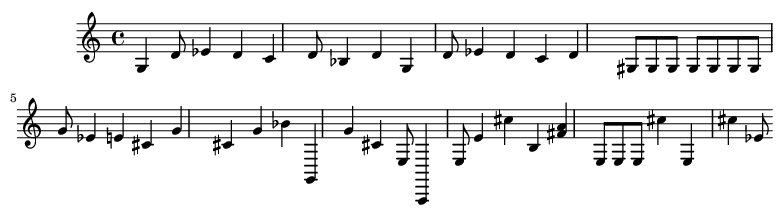

In [31]:
final_notes = converter.parse("outputs/" + result_name)
show_lily(prepare_notes_to_show(final_notes))

In [34]:
seed = 42
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return IPython.display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [35]:
pmf = pretty_midi.PrettyMIDI("outputs/" + result_name)
display_audio(pmf)